In [1]:
import pandas_datareader as pdr
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
tickers = ['SPY', 'IWM', 'MDY', 'QQQ', 'TLT']

start = dt.datetime(2009, 1, 1)
end = dt.datetime(2020, 1, 1)

data = pdr.get_data_yahoo(tickers, start, end)

data = data['Adj Close']

In [76]:
data['Short'] = 1.0
data = data[['SPY', 'IWM', 'MDY', 'QQQ', 'Short', 'TLT']]

In [77]:
data

Symbols,SPY,IWM,MDY,QQQ,Short,TLT
Date,,,,,,
2009-01-02,73.024796,42.390228,85.779068,27.635725,1.0,82.637856
2009-01-05,72.938377,42.542164,86.131493,27.626810,1.0,80.507095
2009-01-06,73.425415,43.259644,87.283340,27.902905,1.0,79.697403
2009-01-07,71.225891,41.985077,84.610016,27.110258,1.0,80.009865
2009-01-08,71.516556,42.187656,85.031212,27.395250,1.0,79.945969
...,...,...,...,...,...,...
2019-12-24,315.341095,164.337219,369.846344,210.720291,1.0,134.519333
2019-12-26,317.019714,164.337219,370.664368,212.579697,1.0,134.843735
2019-12-27,316.941162,163.528748,369.944885,212.400726,1.0,134.991180


In [95]:
position

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [90]:
c = 0
for i in range(5):
    print(i, len(position[position[:,i] == 1]))
    c += len(position[position[:,i] == 1])
print(c)

0 0
1 0
2 0
3 0
4 0
0


In [91]:
len(position)

2516

In [113]:
def calculate(data):
    cagr = (data.iloc[-1]/data.iloc[0])**(1/10) - 1
    
    rolling_max = data.cummax()
    daily_drawdown = data/rolling_max - 1
    drawdown = daily_drawdown.cummin().iloc[-1]

    log_returns = np.log(data/data.shift())
    volatility = log_returns.std()*(252**.5)
    
    return cagr, drawdown, volatility

def evaluate_position(data, position):
    spy_cagr, spy_drawdown, spy_vol = calculate(data['SPY'])
    
    series = (np.log(data/data.shift())*position).sum(axis=1).cumsum().apply(np.exp)
    
    # print(series.head())
    
    bt_cagr, bt_drawdown, bt_vol = calculate(series)
    
    print(spy_cagr, spy_drawdown, spy_vol)
    print(bt_cagr, bt_drawdown, bt_vol)

In [136]:
def get_position(roll=60, split=.6):
    log_returns = np.log(data/data.shift())

    log_returns = log_returns[['SPY', 'IWM', 'MDY', 'QQQ', 'Short']].copy()

    rolling_sum = log_returns.copy()

    for ticker in ['SPY', 'IWM', 'MDY', 'QQQ', 'Short']:
        rolling_sum[ticker] = rolling_sum[ticker].rolling(roll).sum()

    rolling_sum = rolling_sum.loc['2010':]
    log_returns = log_returns.loc['2010':]

    position = rolling_sum.apply(lambda x: x == rolling_sum.max(axis=1)).astype(int).shift().to_numpy()
    position[0] = position[1]

    position *= split

    position = np.append(position, np.ones((len(position), 2))[:,:1]*(1.-split), axis=1)
    
    return position

In [137]:
steps = 10
for i in range(steps + 1):
    print(i/steps)
    evaluate_position(data.loc['2010':], get_position(60, i/steps))

0.0
0.13244548148388002 -0.1934892785101755 0.14717472883158292
0.07236509453270812 -0.20658788677962525 0.1374875755697516
0.1
0.13244548148388002 -0.1934892785101755 0.14717472883158292
0.07431581026167655 -0.1715098399305547 0.11984570755797698
0.2
0.13244548148388002 -0.1934892785101755 0.14717472883158292
0.07627007449467116 -0.13488093527348954 0.10411222125014827
0.3
0.13244548148388002 -0.1934892785101755 0.14717472883158292
0.07822789368669714 -0.10997752309465392 0.09127933181586714
0.4
0.13244548148388002 -0.1934892785101755 0.14717472883158292
0.08018927430450229 -0.09287997348882027 0.08270839757489164
0.5
0.13244548148388002 -0.1934892785101755 0.14717472883158292
0.0821542228265979 -0.09162014219842274 0.07978497635272702
0.6
0.13244548148388002 -0.1934892785101755 0.14717472883158292
0.08412274574328005 -0.10849699382630273 0.08310719994890832
0.7
0.13244548148388002 -0.1934892785101755 0.14717472883158292
0.08609484955665114 -0.1343107305732144 0.09200093328132149
0.8


In [138]:
df = np.log(data.loc['2010':]/data.loc['2010':].shift())*get_position()

<IPython.core.display.Javascript object>


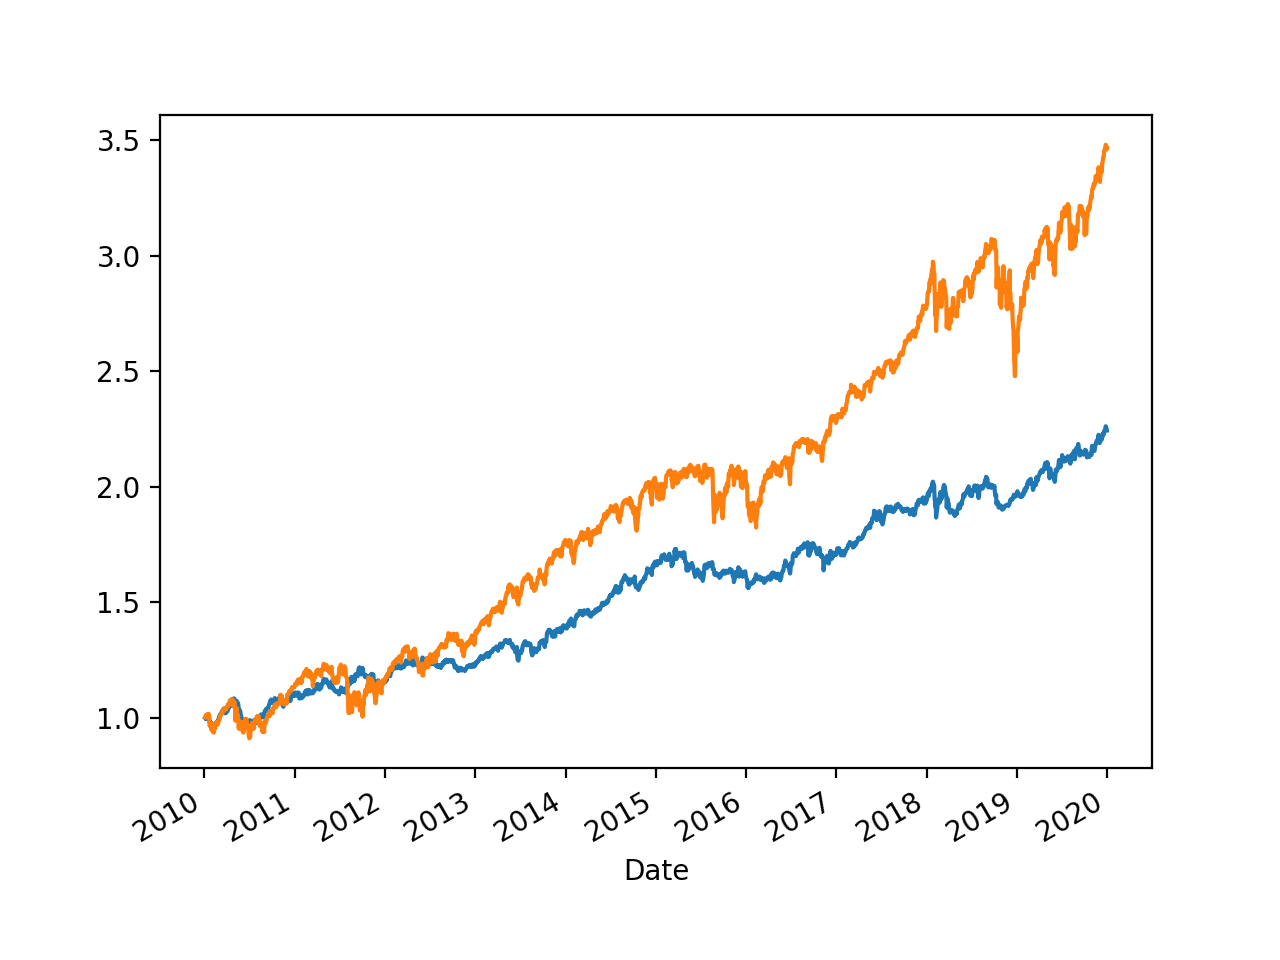

<AxesSubplot:xlabel='Date'>

In [139]:
fig, ax = plt.subplots()
df.sum(axis=1).cumsum().apply(np.exp).plot(ax=ax)

spy = data['SPY'].loc['2010':]
(spy/spy.iloc[0]).plot(ax=ax)